[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# My own example 
## in which the summary function is invoked as soon as the number of messages becomes greater than 4, and the previous messages are deleted and this summary is given as input along with the next human message



In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o",temperature=0)

/Users/rishitkamboj/College/langschain course /.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


### Added the summary key to the MessagesState

In [6]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

### defined the model invocation node with logic

In [7]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
def invoke_model(state: State):
    
    summary = state.get("summary", "")
    
    if summary:
        
        sys_msg = f"Summary of conversation earlier: {summary}\n\n"
        
        msgs = [SystemMessage(content=sys_msg)] + state["messages"]
    
    else:
        msgs = state["messages"]
    
    result = llm.invoke(msgs)
    return {"messages": result}

### defined the node to generate the summary

In [8]:

def generate_summary(state: State):
    

    summary = state.get("summary", "")
    if summary:
        summary_msg = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_msg = "Create a summary of the conversation above."
    
    # Add prompt to our history
    msgs = state["messages"] + [HumanMessage(content=summary_msg)]
    result = llm.invoke(msgs)
    
    # Delete all but the 2 most recent messages
    remove_msgs = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": result.content, "messages": remove_msgs}

In [9]:
from langgraph.graph import END
from typing_extensions import Literal

def check_continuation(state: State) -> Literal["generate_summary", END]:
    """Return the next node to execute."""
    
    msgs = state["messages"]
    
    # If there are more than 4 messages, then we generate the summary
    if len(msgs) > 4:
        return "generate_summary"
    
    # Otherwise we can just end
    return END

In [10]:
# Cell 7: Define Conditional Logic
# We'll add a conditional edge to determine whether to produce a summary based on the conversation length
from langgraph.graph import END
from typing_extensions import Literal

def check_continuation(state: State) -> Literal["generate_summary", END]:
    """Return the next node to execute."""
    
    msgs = state["messages"]
    
    # If there are more than 4 messages, then we generate the summary
    if len(msgs) > 4:
        return "generate_summary"
    
    # Otherwise we can just end
    return END

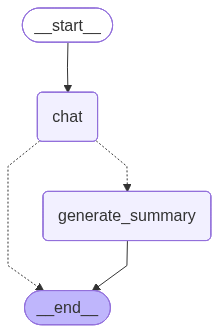

In [11]:
 #Cell 8: Build the Graph
# Adding memory section
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
wflow = StateGraph(State)
wflow.add_node("chat", invoke_model)
wflow.add_node("generate_summary", generate_summary)

# Set the entrypoint as chat
wflow.add_edge(START, "chat")
wflow.add_conditional_edges("chat", check_continuation)
wflow.add_edge("generate_summary", END)

# Compile
mem = MemorySaver()
app = wflow.compile(checkpointer=mem)
display(Image(app.get_graph().draw_mermaid_png()))


In [12]:
# Cell 9: Start Conversation - Message 1
# Create a thread
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
cfg = {"configurable": {"thread_id": "4"}}

# Start conversation
msg_input = HumanMessage(content="Hi! I'm rishit, My university SNU has UWEs and mine is mat 496")
result = app.invoke({"messages": [msg_input]}, cfg)
for msg in result['messages'][-1:]:
    msg.pretty_print()


================================== Ai Message ==================================

Hi Rishit! It sounds like you're preparing for your University Wide Examinations (UWEs) at SNU, specifically for MAT 496. If you have any questions about the course material, need study tips, or want to discuss specific topics, feel free to ask. Good luck with your studies!


In [13]:
# Cell 10: Continue Conversation - Message 2
msg_input = HumanMessage(content="What's my name?")
result = app.invoke({"messages": [msg_input]}, cfg)
for msg in result['messages'][-1:]:
    msg.pretty_print()



================================== Ai Message ==================================

Your name is Rishit.


In [14]:
# Cell 11: Continue Conversation - Message 3
msg_input = HumanMessage(content="My course is about LLMs and understanding them")
result = app.invoke({"messages": [msg_input]}, cfg)
for msg in result['messages'][-1:]:
    msg.pretty_print()


================================== Ai Message ==================================

That sounds like a fascinating course! LLMs, or Large Language Models, are a significant area of study in artificial intelligence and natural language processing. They involve understanding how these models are trained, how they generate text, and their applications and limitations. If you have any specific questions about LLMs or need help with certain topics, feel free to ask!


### now after this call our messages exceeded 4 so we can see in langsmith that the summary function was invoked and our llm created a summary of our previous ocnversation and deleted the previous messages:

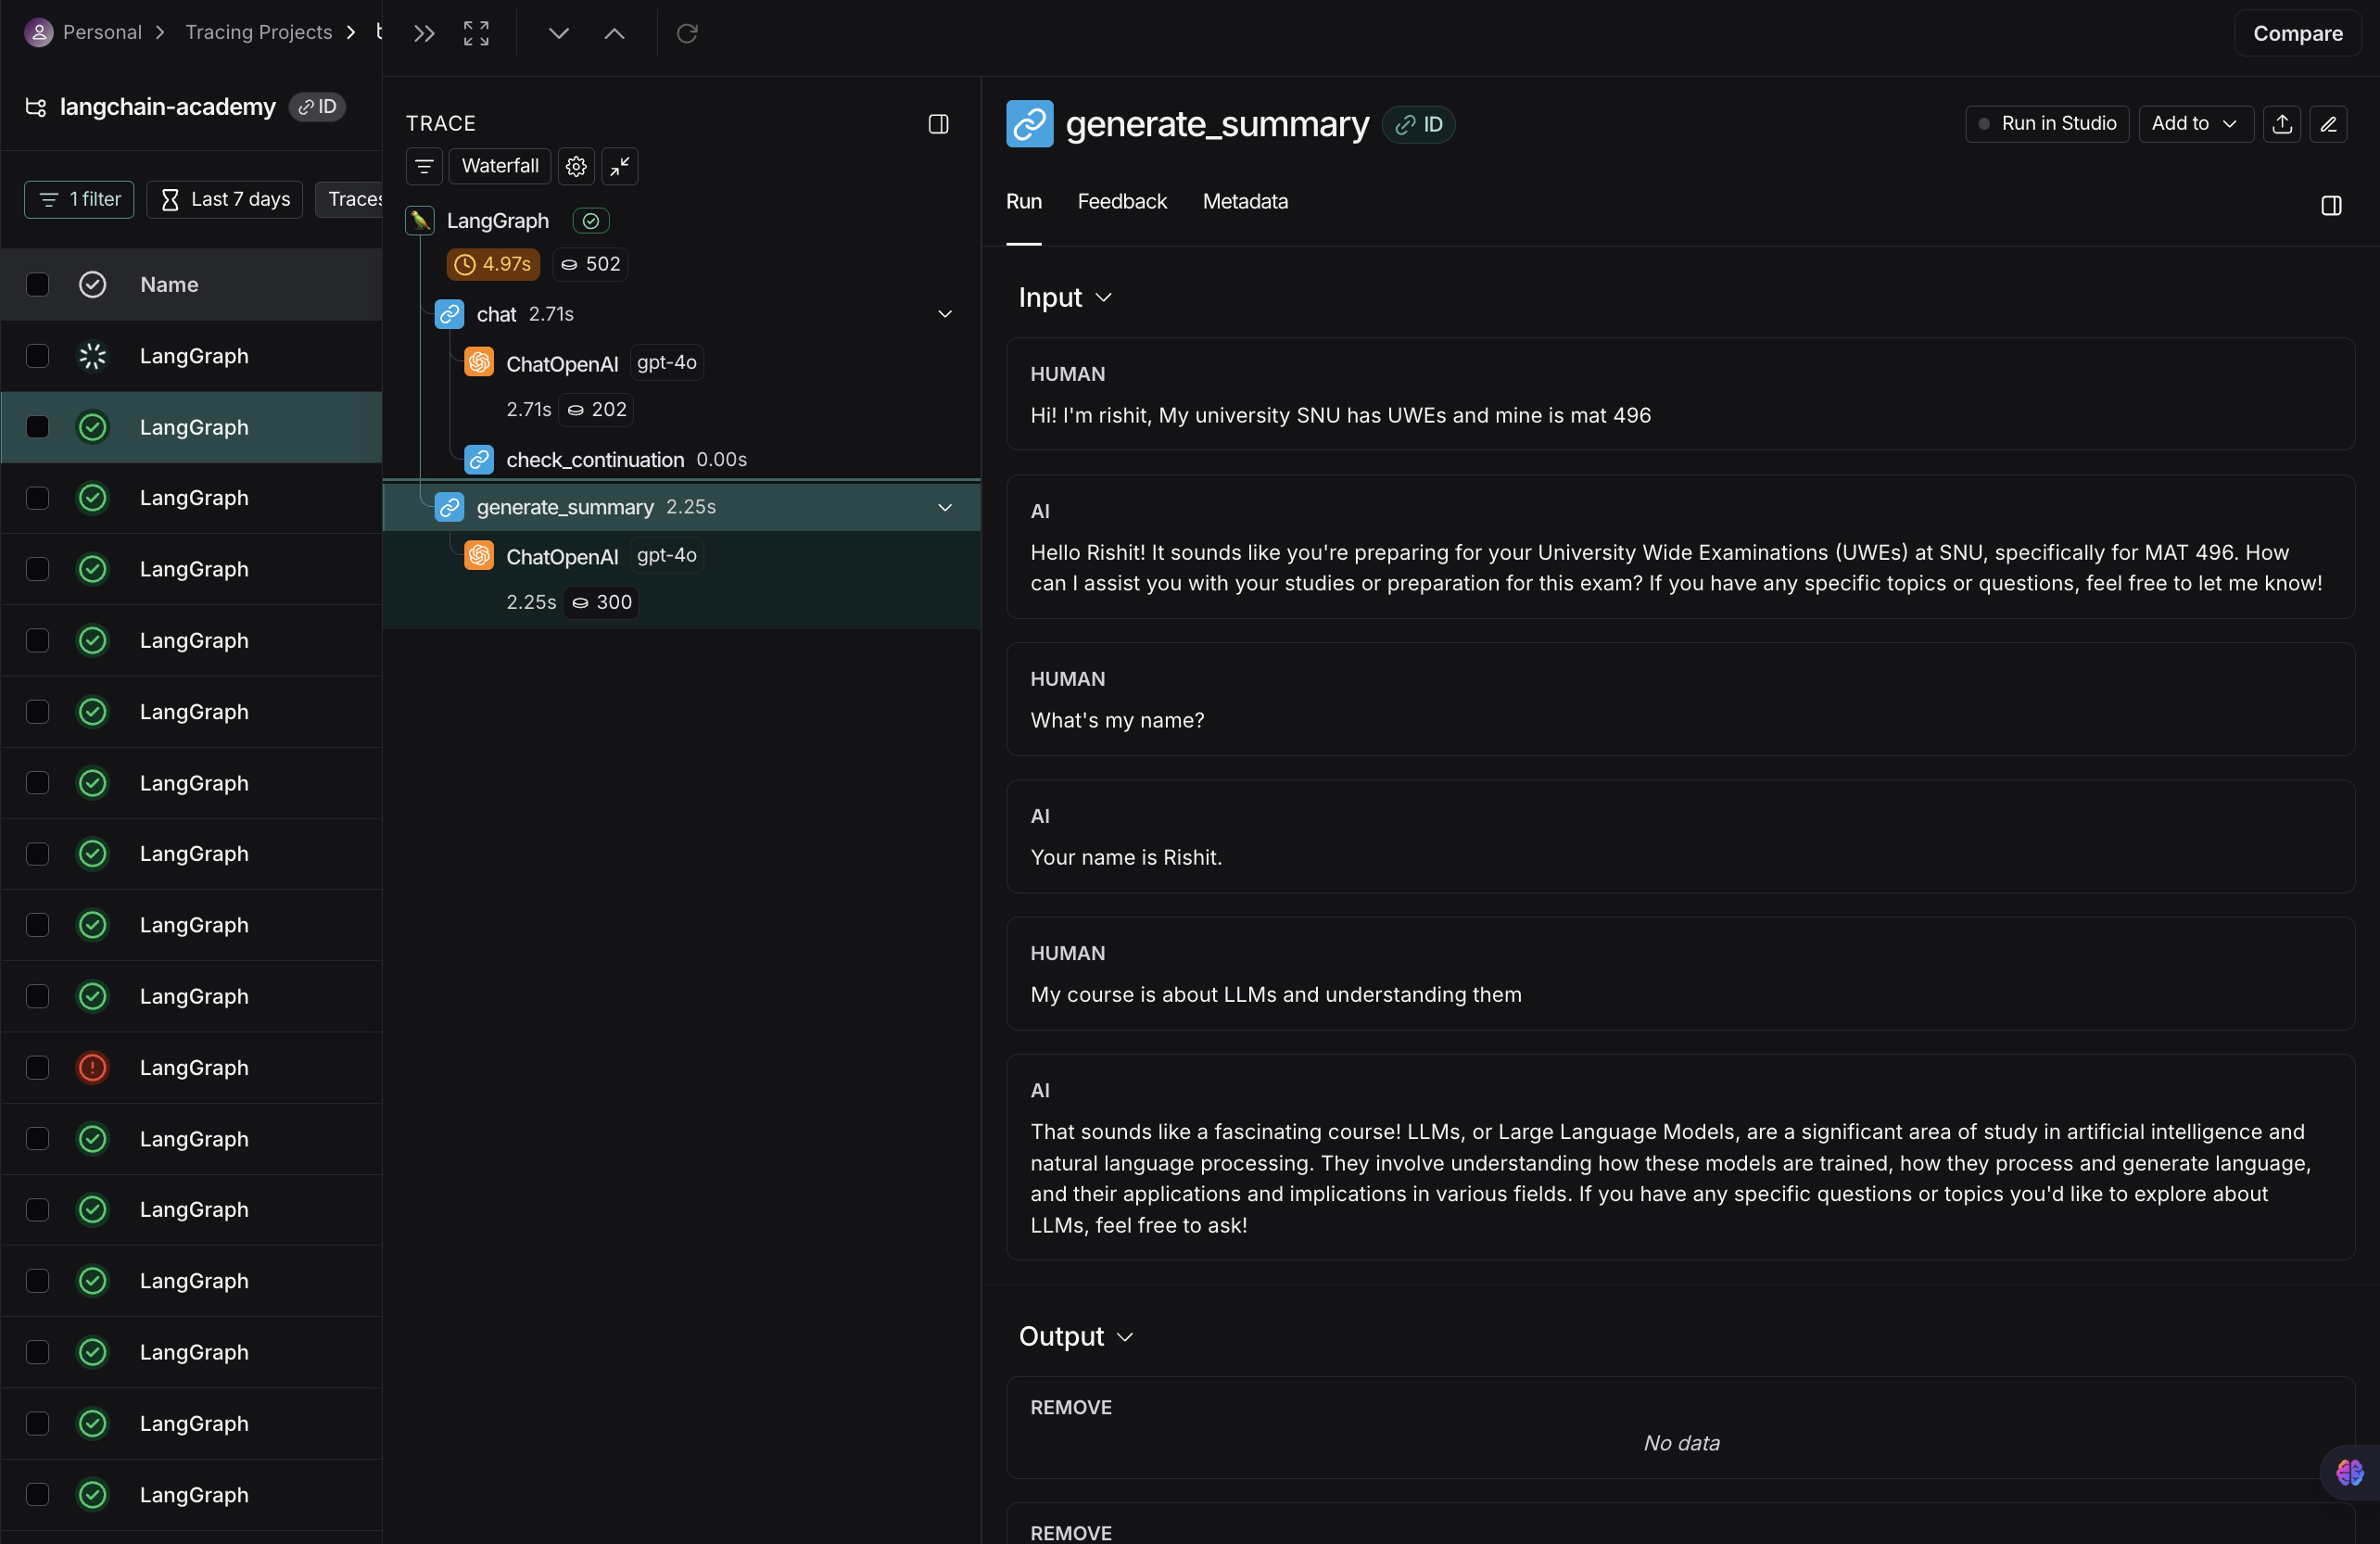

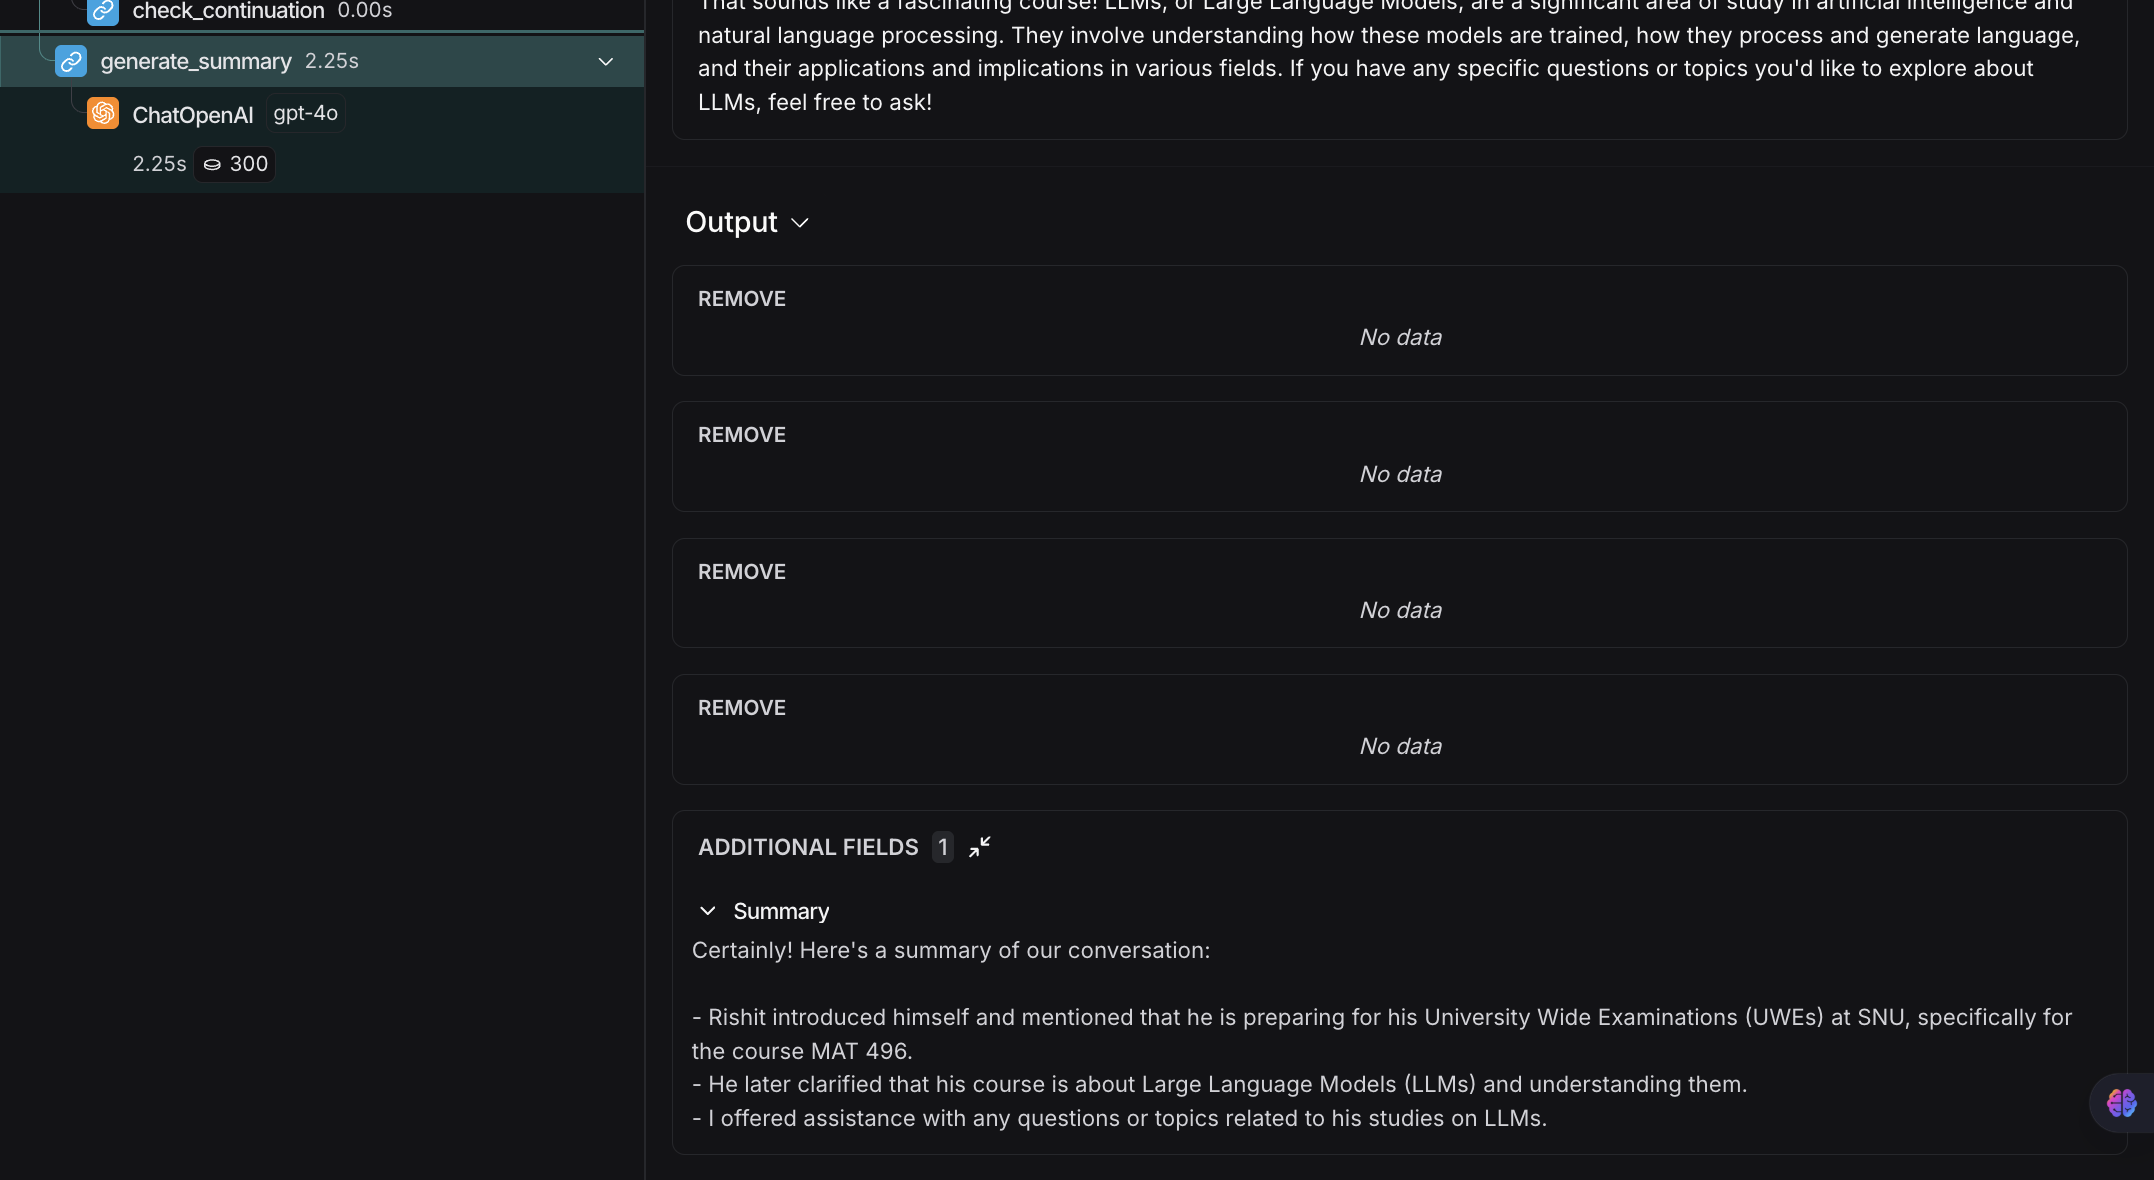

In [15]:
# Cell 13: Continue Conversation - Message 4
# The cfg with thread ID allows us to proceed from the previously logged state!

msg_input = HumanMessage(content="Mr. ajit kumar in my prof for this course btw")
result = app.invoke({"messages": [msg_input]}, cfg)
for msg in result['messages'][-1:]:
    msg.pretty_print()



================================== Ai Message ==================================

That's great to know! Having a knowledgeable professor like Mr. Ajit Kumar can be very beneficial for diving deep into the subject of Large Language Models. If you have any specific questions about the course content or need clarification on topics discussed in class, feel free to reach out. I'm here to help!


### imstead of passing all the messages to our LLM we now only pass the summary and the two most recent messages which significantly increases the efficiency of the process :

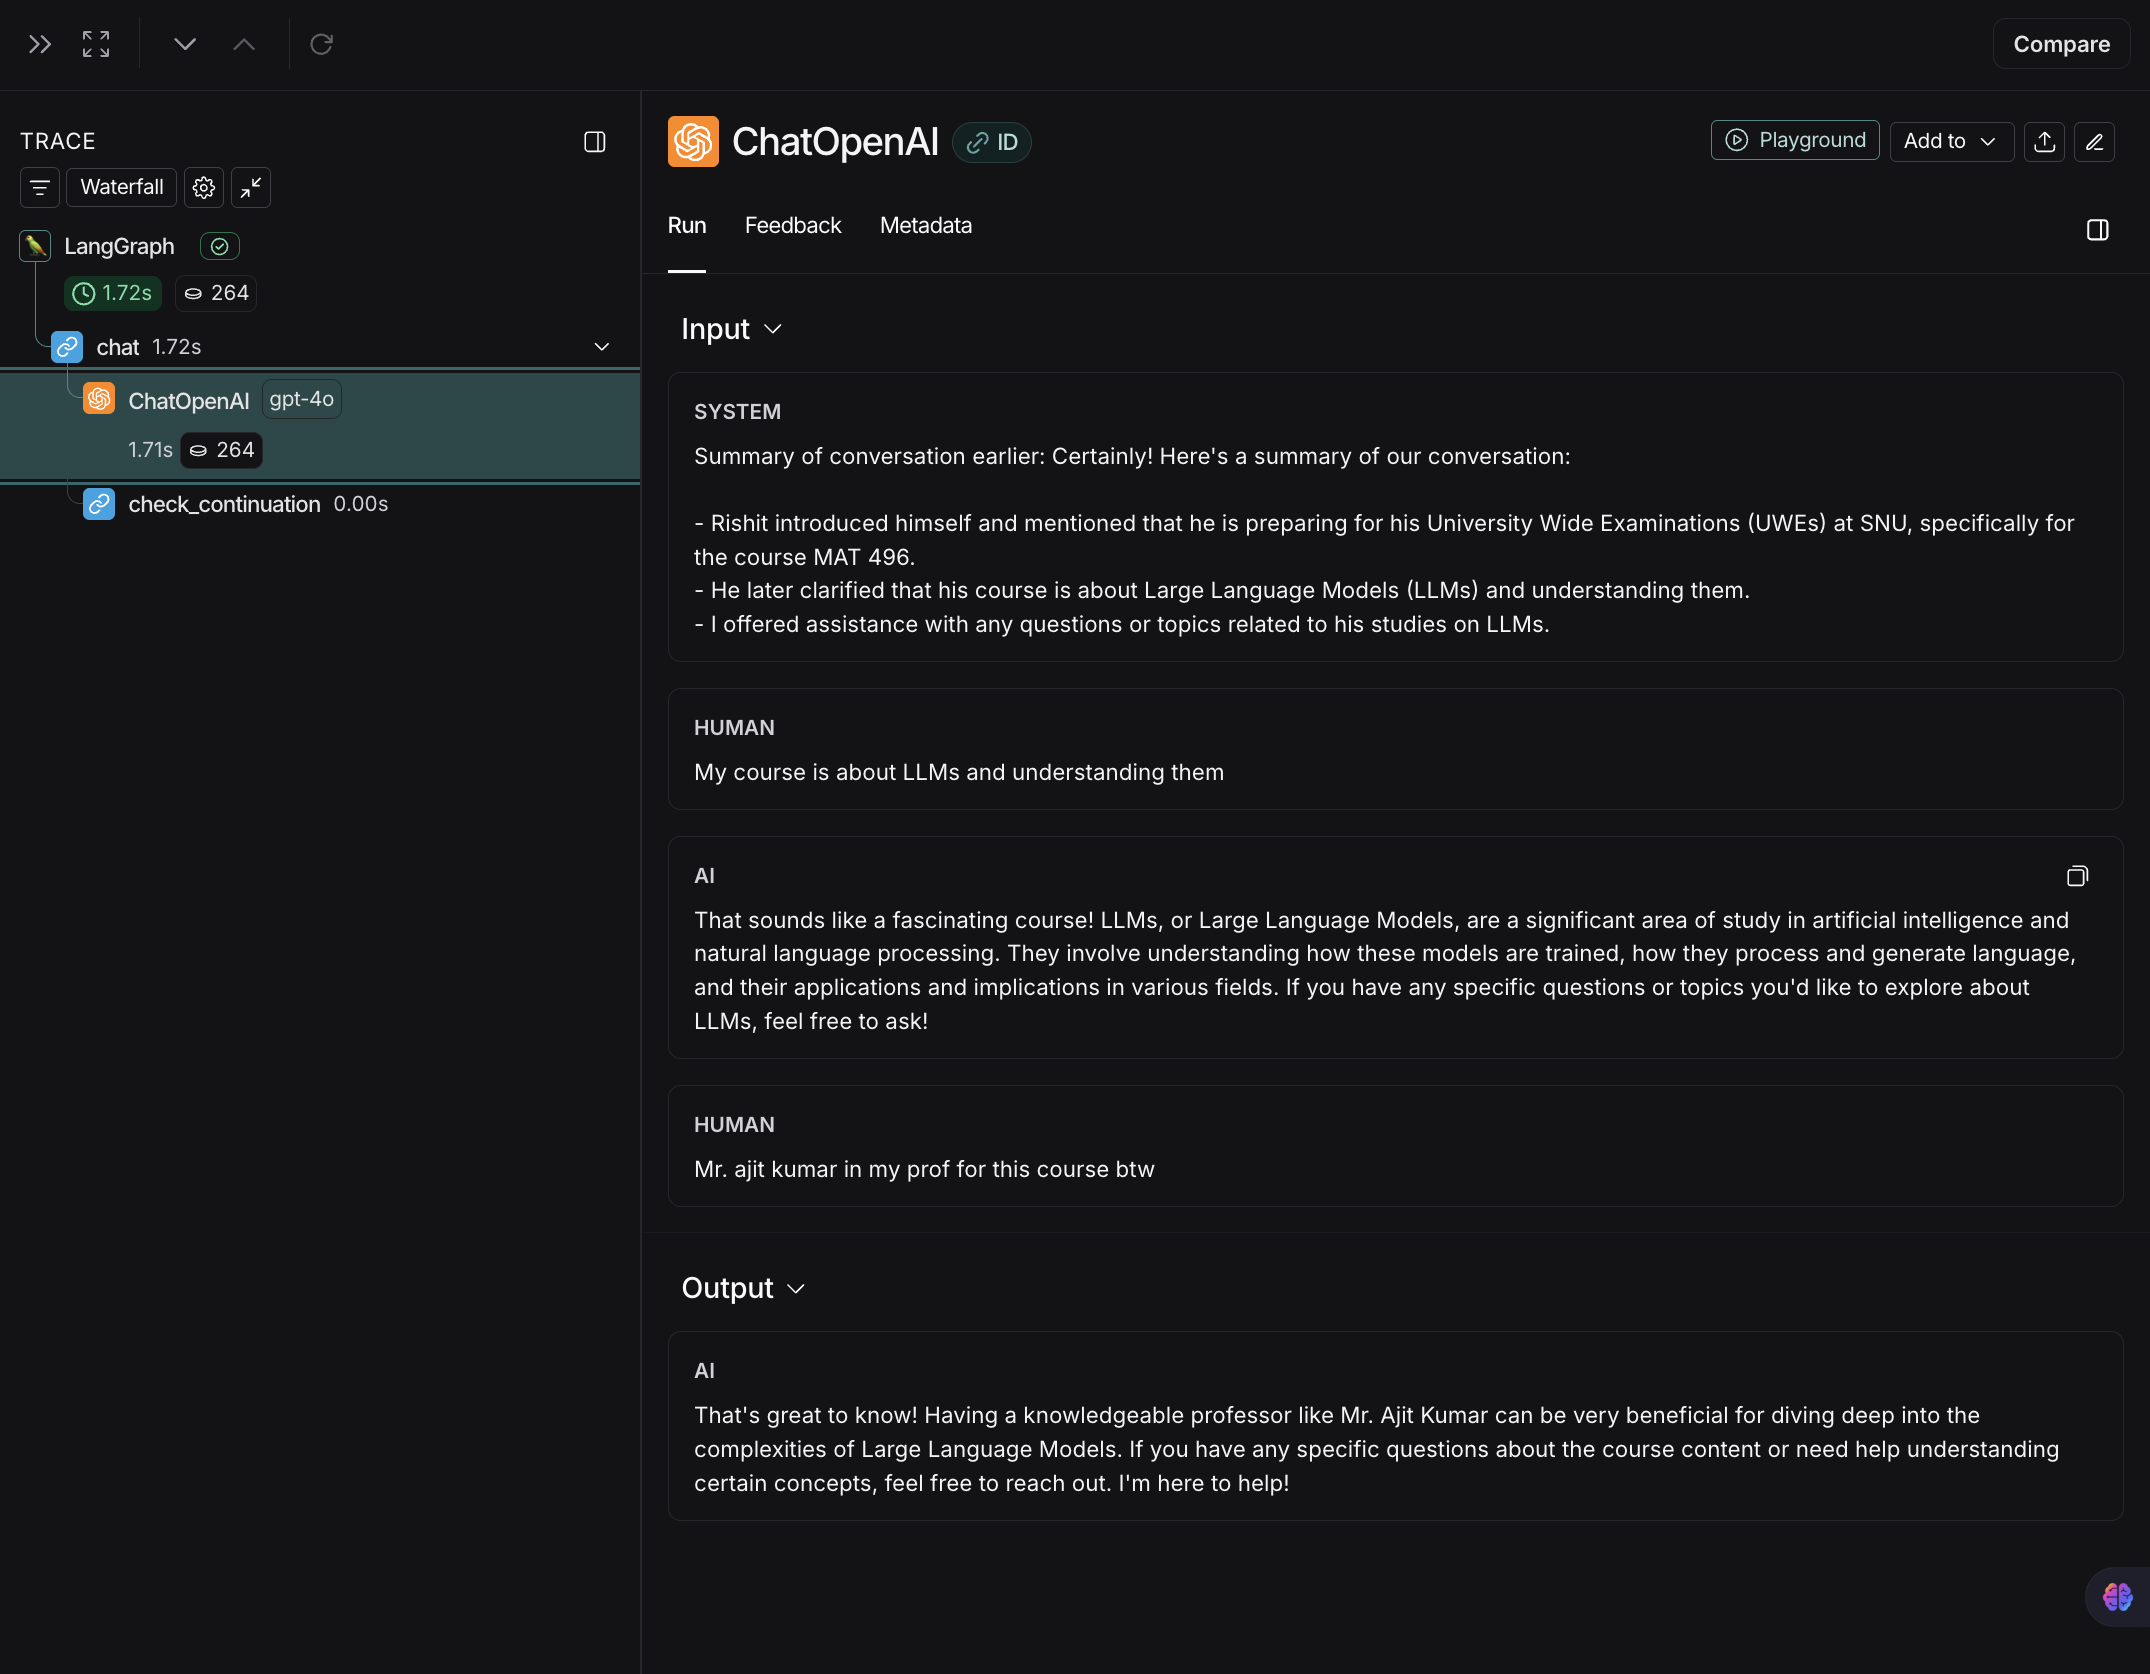

## experimenting with another example :


In [16]:


# Cell 16: New Conversation - Thread 5, Message 1
# Create a new thread for a different conversation
cfg_new = {"configurable": {"thread_id": "5"}}

# Start new conversation about Daytona 24hr race
msg_input = HumanMessage(content="Hey! I'm really excited about the Daytona 24 hour race!")
result = app.invoke({"messages": [msg_input]}, cfg_new)
for msg in result['messages'][-1:]:
    msg.pretty_print()



================================== Ai Message ==================================

That's great to hear! The Rolex 24 at Daytona is a thrilling event and a highlight in the motorsport calendar. It takes place at the Daytona International Speedway in Daytona Beach, Florida, and is part of the IMSA WeatherTech SportsCar Championship. The race features a diverse lineup of cars and drivers, including prototypes and GT cars, and attracts teams and drivers from all over the world. Whether you're a fan of endurance racing or just love the excitement of motorsports, the Daytona 24-hour race is definitely an event to look forward to. Do you have any favorite teams or drivers you're rooting for?


In [17]:
# Cell 17: Thread 5, Message 2
msg_input = HumanMessage(content="Who are some of the top drivers competing this year?")
result = app.invoke({"messages": [msg_input]}, cfg_new)
for msg in result['messages'][-1:]:
    msg.pretty_print()



================================== Ai Message ==================================

The Rolex 24 at Daytona typically features a star-studded lineup of drivers from various racing disciplines, including sports cars, IndyCar, NASCAR, and even Formula 1. While I don't have the specific entry list for the most recent race, some of the top drivers who frequently compete in this event include:

1. **Scott Dixon** - A six-time IndyCar champion who often competes in endurance races.
2. **Helio Castroneves** - A multiple-time Indy 500 winner who has also found success in sports car racing.
3. **Ricky Taylor** - A prominent figure in the IMSA series and a past winner of the Rolex 24.
4. **Kamui Kobayashi** - A former F1 driver who has achieved success in endurance racing, including wins at Daytona.
5. **Renger van der Zande** - Known for his skills in prototype racing and a previous winner at Daytona.
6. **Colin Braun** - A versatile driver with experience in various racing series, including IMSA

In [18]:
# Cell 18: Thread 5, Message 3
msg_input = HumanMessage(content="I think Acura has a strong team. What do you think about their chances?")
result = app.invoke({"messages": [msg_input]}, cfg_new)
for msg in result['messages'][-1:]:
    msg.pretty_print()



================================== Ai Message ==================================

Acura has indeed been a strong contender in the IMSA WeatherTech SportsCar Championship, particularly in the Daytona Prototype international (DPi) class, which is now known as the GTP class with the introduction of the LMDh regulations. Acura's partnership with teams like Wayne Taylor Racing and Meyer Shank Racing has yielded impressive results in recent years.

Acura's strengths typically include:

1. **Strong Driver Lineup**: Acura often fields experienced and talented drivers, many of whom have a proven track record in endurance racing. This depth of talent is crucial for a 24-hour race.

2. **Competitive Engineering**: The Acura ARX-05, and now the ARX-06 under the new regulations, has been a well-engineered car, known for its speed and reliability, both critical factors in endurance racing.

3. **Team Experience**: Teams like Wayne Taylor Racing and Meyer Shank Racing have extensive experience in end

### the summary function was invoked as soon as the messages crossed 4 in number : 

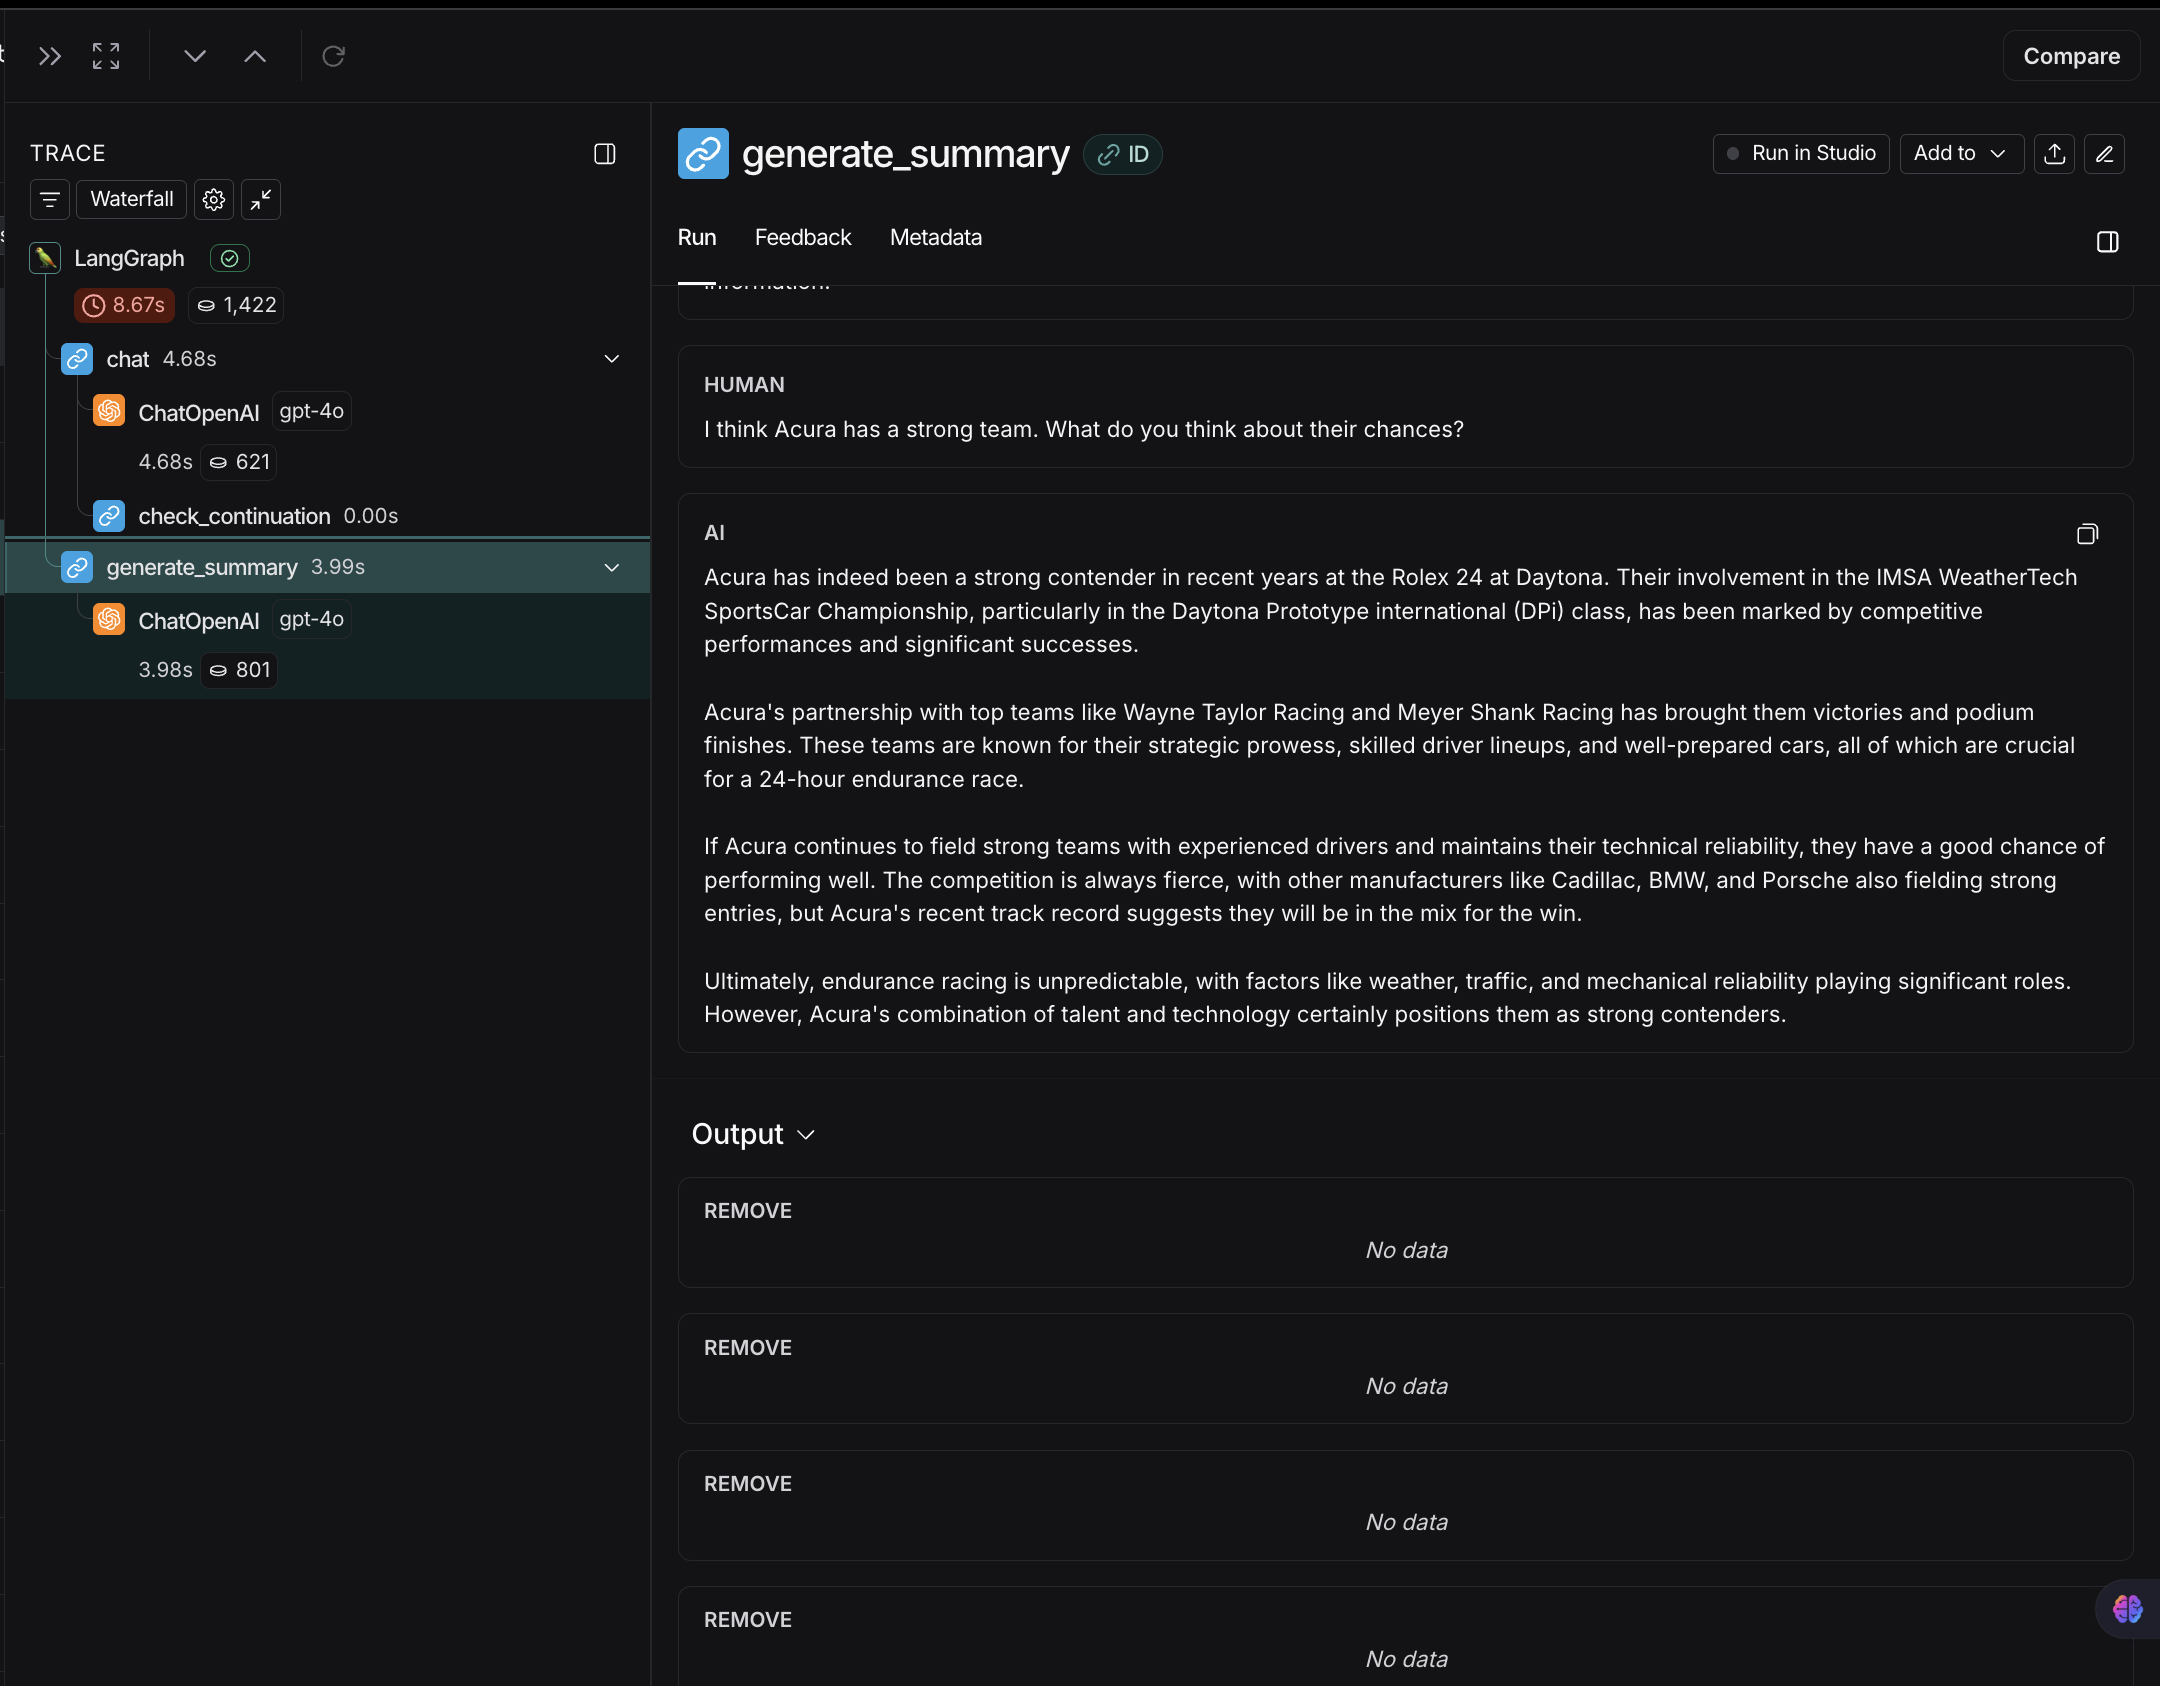

In [ ]:
# Cell 19: Thread 5, Message 4
msg_input = HumanMessage(content="How many classes compete in the race?")
result = app.invoke({"messages": [msg_input]}, cfg_new)
for msg in result['messages'][-1:]:
    msg.pretty_print()



### then for the next input, the summary generated in the previous message was included as input : 
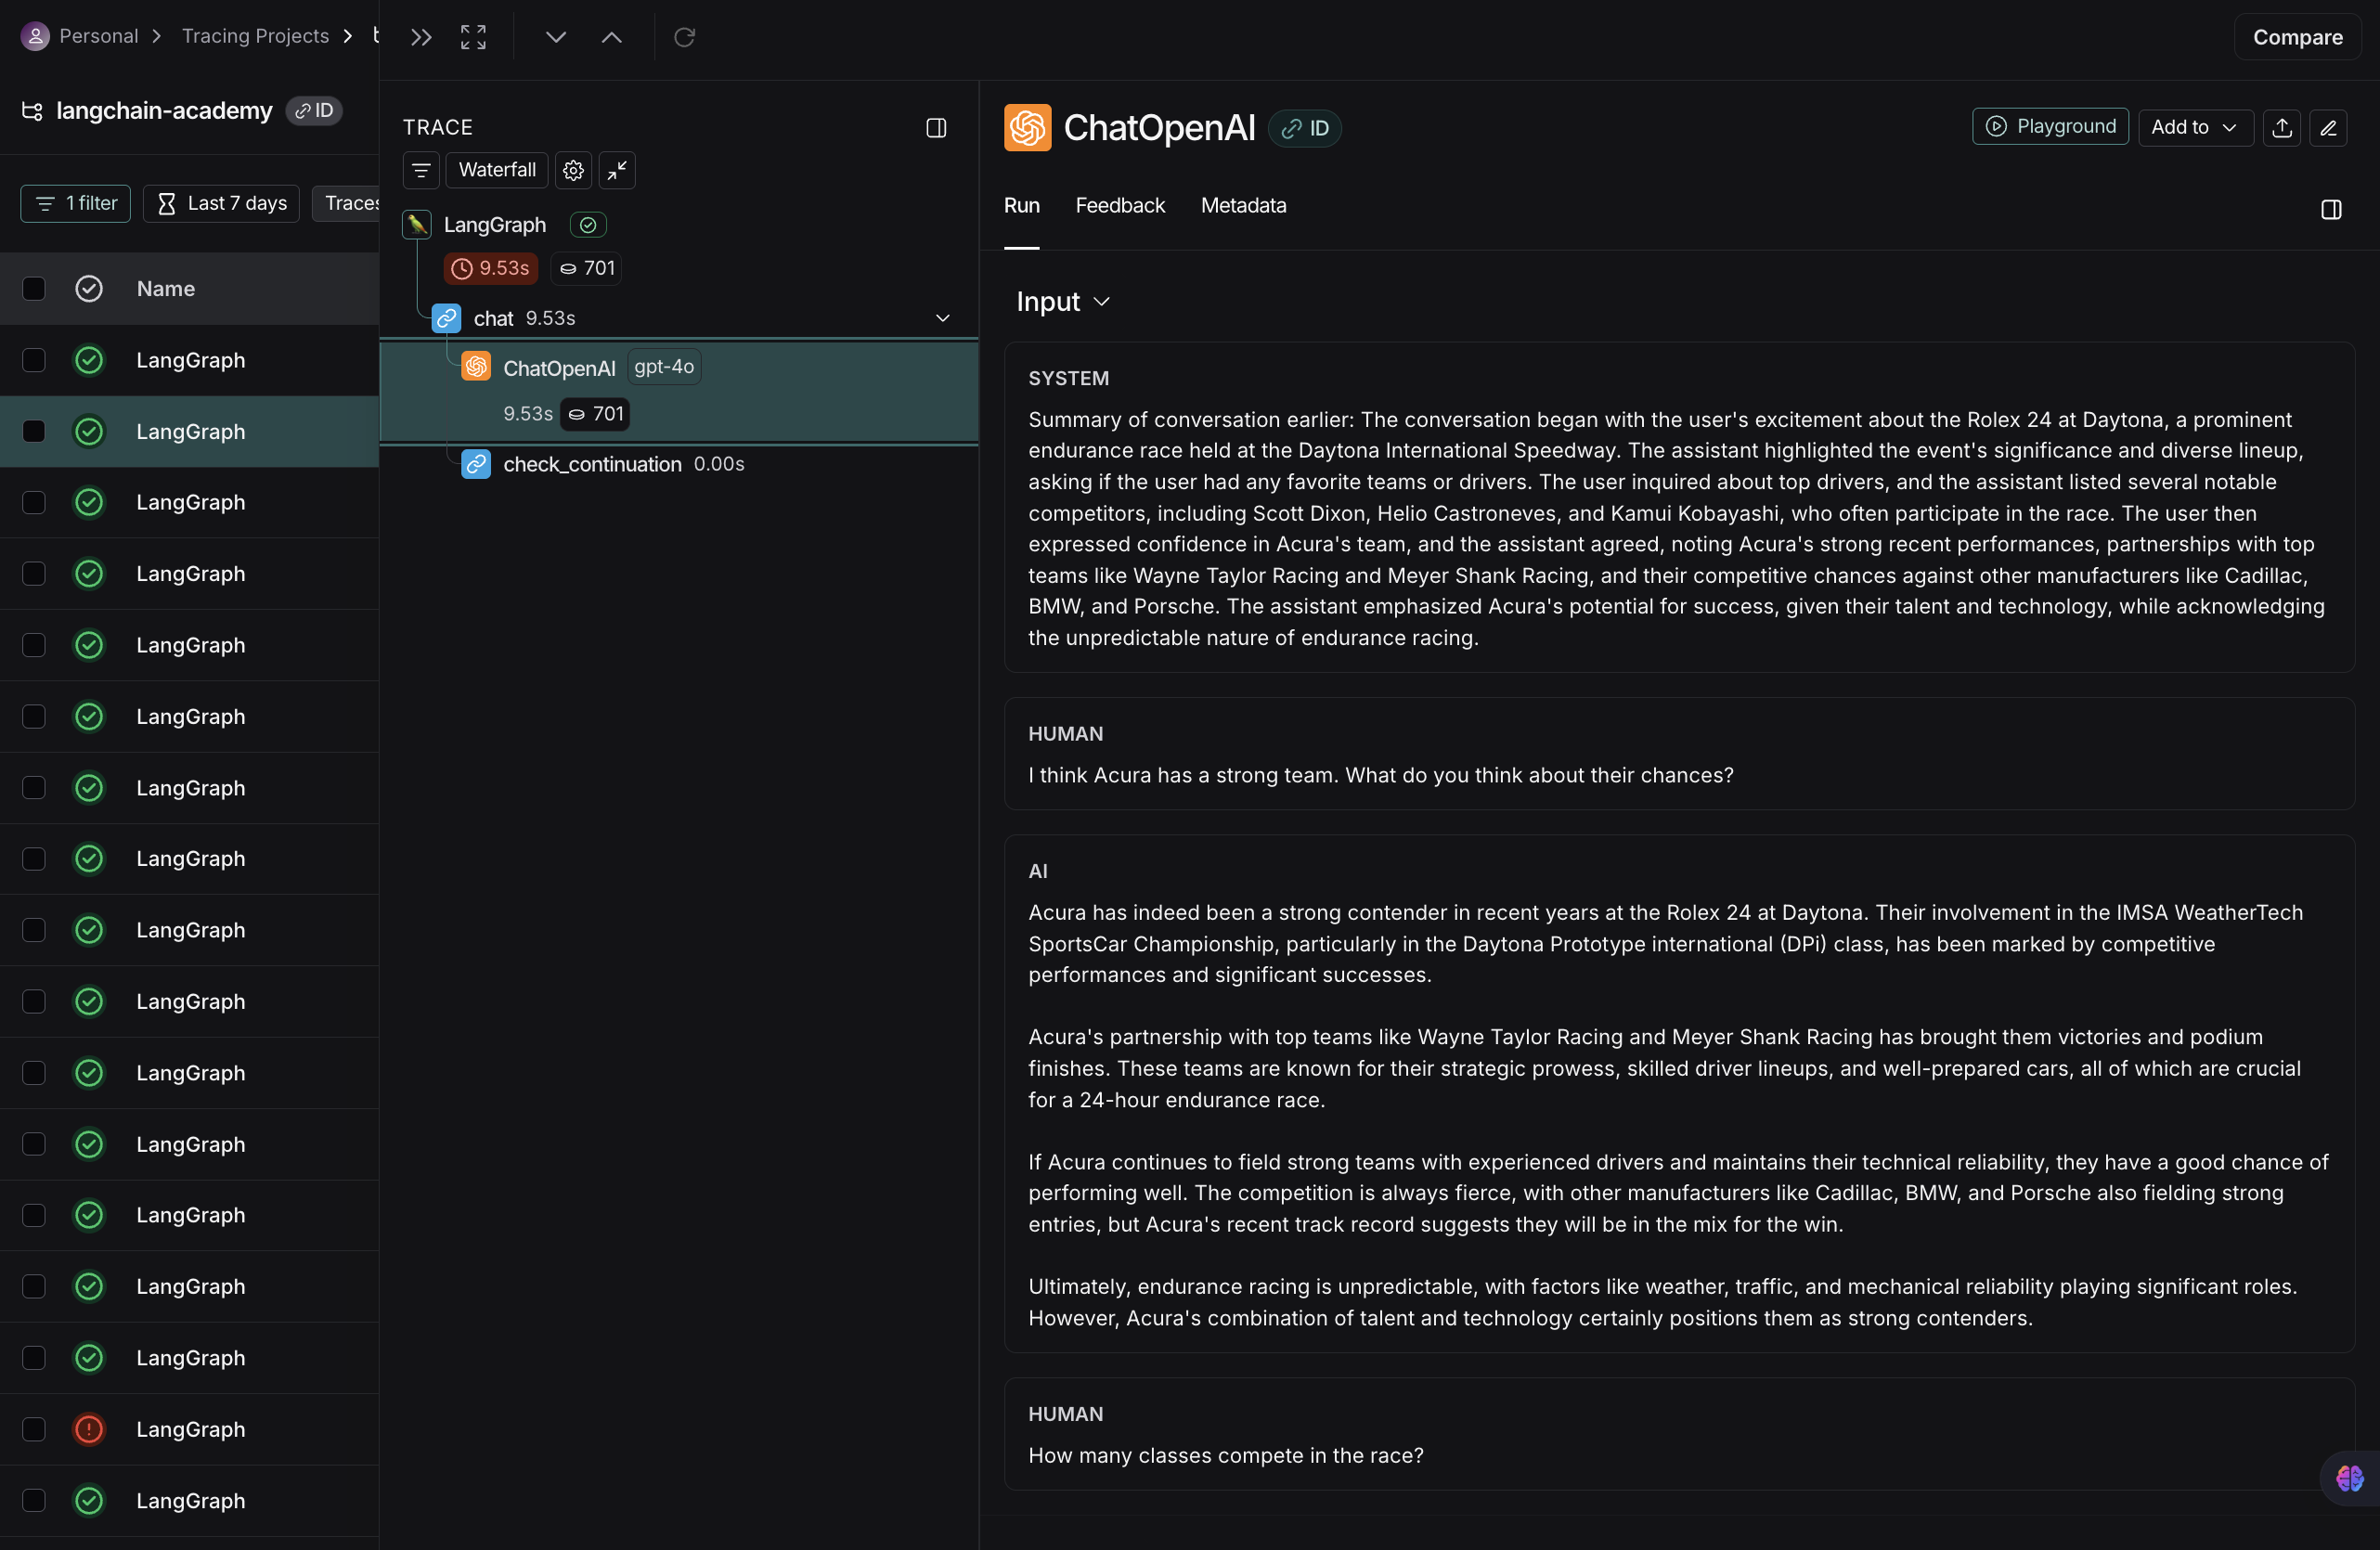

In [ ]:
# Cell 20: Thread 5, Message 5
msg_input = HumanMessage(content="What makes endurance racing so challenging compared to regular races?")
result = app.invoke({"messages": [msg_input]}, cfg_new)
for msg in result['messages'][-1:]:
    msg.pretty_print()

### then generate summary was invoked again because the messages crossed 4 in number once again : 

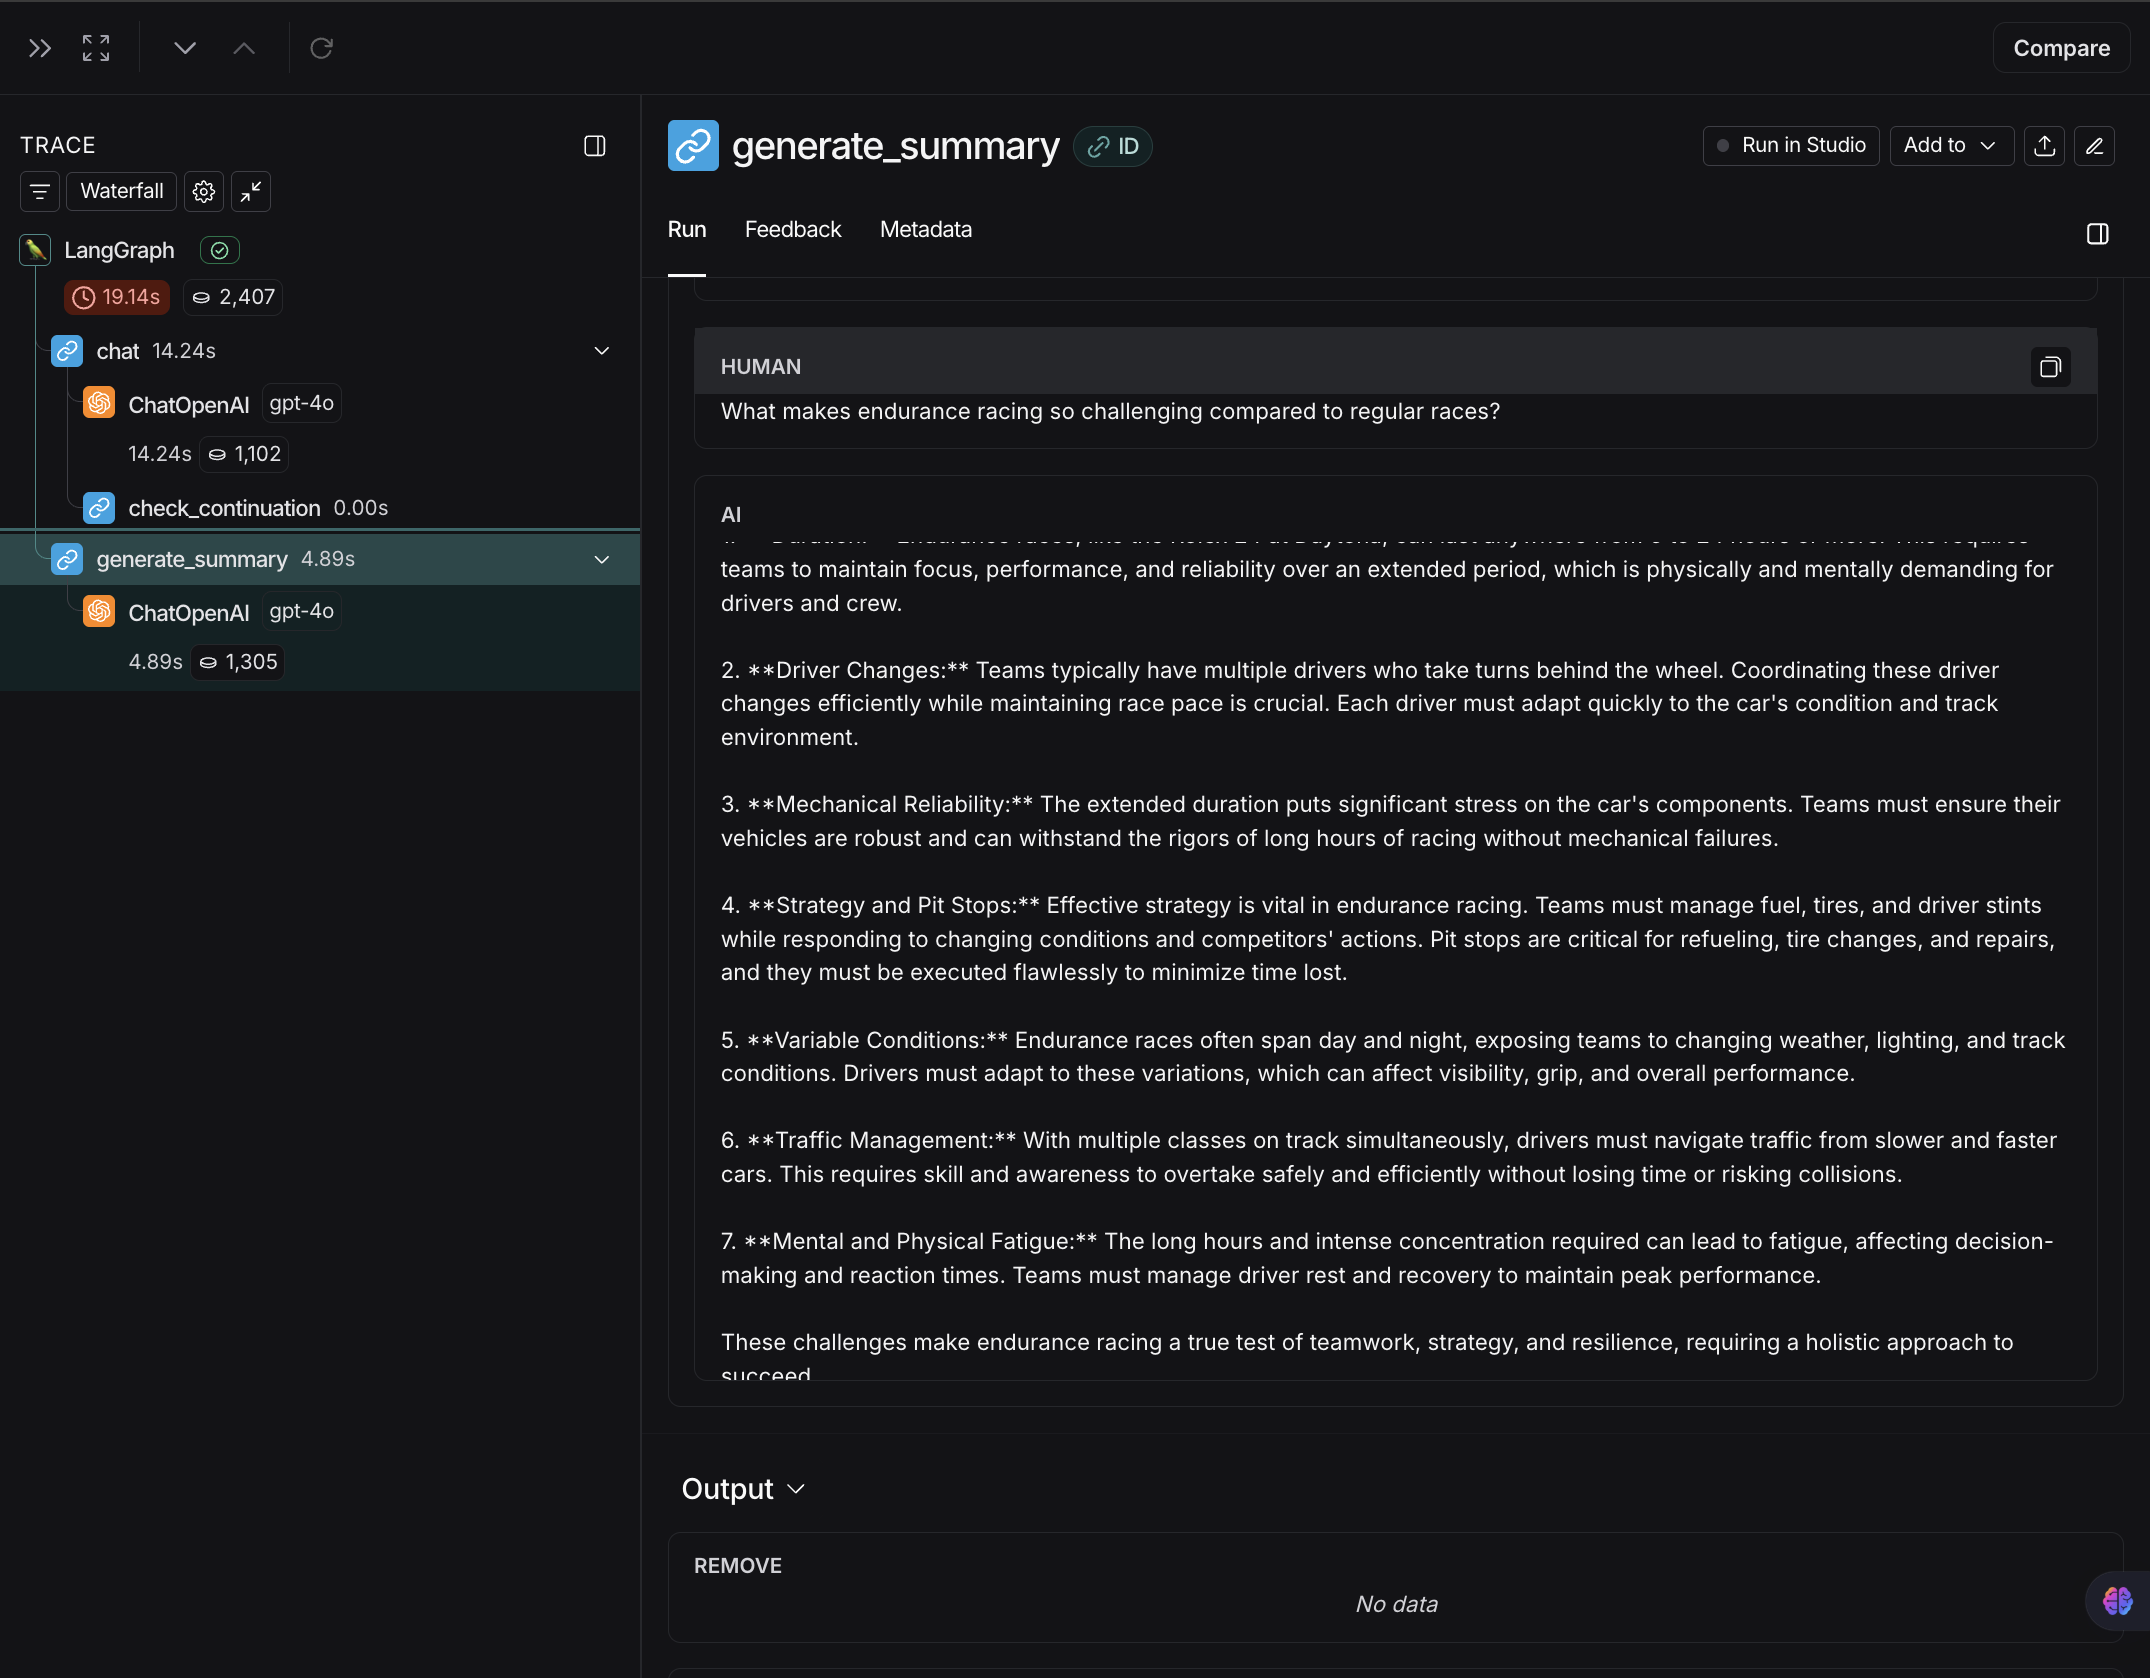